### These are the libraries we will need for the classification task

In [12]:
import os
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix


### Firstly we declare the path of the data for the classification task and also parameters for our CNN

In [13]:
DATA_DIR = r"C:\Unipi-CS\Πτυχιακή\datasets\raw\classification_task\train"  
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_CLASSES = 4
EPOCHS = 12
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CLASS_NAMES = ['glioma', 'meningioma', 'no_tumor','pituitary'] 

In [14]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print("Device:", DEVICE)

Device: cpu


In [15]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

In [16]:
full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=train_transform)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size],
                                         generator=torch.Generator().manual_seed(SEED))

In [17]:
val_dataset.dataset = datasets.ImageFolder(root=DATA_DIR, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

In [18]:
print(f"Dataset sizes -> train: {len(train_dataset)}, val: {len(val_dataset)}")

Dataset sizes -> train: 4000, val: 1000


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),  
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),   
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128),
            nn.MaxPool2d(2)                                                  
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(128 * (IMG_SIZE // 8) * (IMG_SIZE // 8), 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
def get_resnet18(num_classes=4, pretrained=True):
    model = models.resnet18(pretrained=pretrained)
   
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

In [21]:
use_resnet = True
if use_resnet:
    model = get_resnet18(NUM_CLASSES, pretrained=True)
else:
    model = SimpleCNN(NUM_CLASSES)

model = model.to(DEVICE)
print(model)

c:\Users\alexi\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alexi\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

c:\Users\alexi\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/12  train_loss: 0.2904  train_acc: 0.8865  val_loss: 0.1650  val_acc: 0.9420
Saved best model -> best_brisc_pytorch.pth
Epoch 2/12  train_loss: 0.1055  train_acc: 0.9620  val_loss: 0.0772  val_acc: 0.9750
Saved best model -> best_brisc_pytorch.pth
Epoch 3/12  train_loss: 0.0528  train_acc: 0.9838  val_loss: 0.0668  val_acc: 0.9750
Saved best model -> best_brisc_pytorch.pth
Epoch 4/12  train_loss: 0.0506  train_acc: 0.9818  val_loss: 0.0615  val_acc: 0.9790
Saved best model -> best_brisc_pytorch.pth
Epoch 5/12  train_loss: 0.0266  train_acc: 0.9925  val_loss: 0.1206  val_acc: 0.9630
Epoch 6/12  train_loss: 0.0304  train_acc: 0.9898  val_loss: 0.0619  val_acc: 0.9840
Epoch 7/12  train_loss: 0.0301  train_acc: 0.9898  val_loss: 0.0460  val_acc: 0.9870
Saved best model -> best_brisc_pytorch.pth
Epoch 8/12  train_loss: 0.0184  train_acc: 0.9935  val_loss: 0.0635  val_acc: 0.9820
Epoch 9/12  train_loss: 0.0138  train_acc: 0.9962  val_loss: 0.0428  val_acc: 0.9880
Saved best model -> 

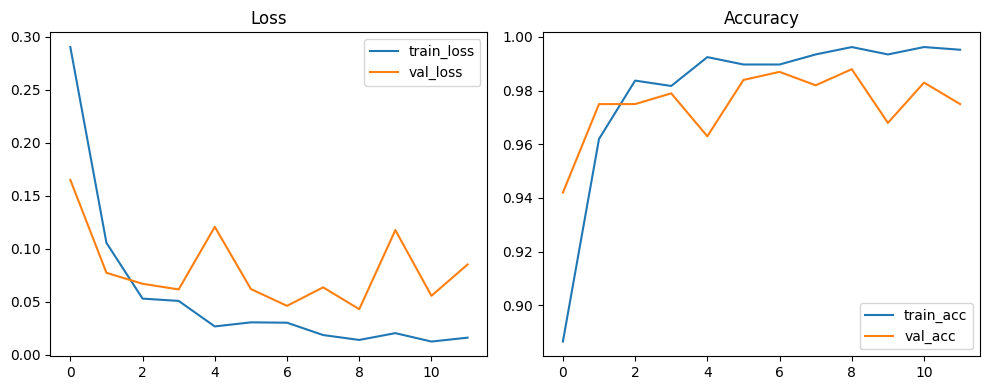

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.3, patience=3
)



def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def eval_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, np.array(all_preds), np.array(all_labels)

best_val_loss = float('inf')
best_model_path = "best_brisc_pytorch.pth"

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, EPOCHS+1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc, _, _ = eval_model(model, val_loader, criterion, DEVICE)
    scheduler.step(val_loss)

    train_losses.append(train_loss); val_losses.append(val_loss)
    train_accs.append(train_acc); val_accs.append(val_acc)

    print(f"Epoch {epoch}/{EPOCHS}  train_loss: {train_loss:.4f}  train_acc: {train_acc:.4f}  val_loss: {val_loss:.4f}  val_acc: {val_acc:.4f}")

    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss
        }, best_model_path)
        print("Saved best model ->", best_model_path)


checkpoint = torch.load(best_model_path, map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
print("Loaded best model from epoch", checkpoint['epoch'])

val_loss, val_acc, y_pred, y_true = eval_model(model, val_loader, criterion, DEVICE)
print(f"\nFinal validation loss: {val_loss:.4f}  acc: {val_acc:.4f}")

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion matrix:\n", cm)

final_path = "brisc2025_cnn_final.pth"
torch.save(model.state_dict(), final_path)
print("Saved final model weights ->", final_path)


plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(train_accs, label='train_acc')
plt.plot(val_accs, label='val_acc')
plt.legend(); plt.title('Accuracy')

plt.tight_layout()
plt.savefig("training_plot.png")
print("Saved training_plot.png")